In [1]:
import torch 
import torchvision
from torchvision import datasets,transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
import os
model_path = 'model_name.pth'
model_params_path = 'params_name.pth'
'''
model = torch.load(model_path, weights_only=False)
这条警告信息来自 PyTorch，它提醒您在使用 torch.load 函数加载模型时可能会面临的安全风险。
具体来说，当 weights_only=False（这是当前的默认值）时，torch.load 会使用
默认的 pickle 模块来反序列化数据。然而，pickle 模块存在一个安全隐患，即它可以构造恶意数据，在反序列化时执行任意代码。

为了缓解这个安全风险，PyTorch 计划在未来的版本中将 weights_only 的默认值改为 True。
当 weights_only=True 时，torch.load 将只加载模型的权重，而不会加载任何可能包含恶意代码的任意对象。
这将限制在反序列化过程中可以执行的函数，从而提高安全性。
警告信息还提到，如果您需要加载包含任意对象的模型（这些对象不在默认的安全白名单中），
您需要使用 torch.serialization.add_safe_globals 函数显式地将它们添加到白名单中。
但是，在大多数情况下，推荐的做法是只加载模型的权重，而不是整个模型对象。
'''
transform = transforms.Compose([transforms.ToTensor(),
            transforms.Normalize(mean=[0.5],
            std=[0.5])])
'''
我们可以将以上代码中的torchvision.transforms.Compose类看作一种容器，
它能够同时对多种数据变换进行组合。传入的参数是一个列表，列表中的元素就
是对载入的数据进行的各种变换操作。在经过标准化变换之后，数据全部符合均
值为0、标准差为1的标准正态分布。
'''


data_train = datasets.MNIST(root = "./data/",
                transform=transform,
                train = True,
                download = True)

data_test = datasets.MNIST(root = "./data/",
            transform = transform,
            train = False)




data_loader_train = torch.utils.data.DataLoader(
        dataset = data_train,
        batch_size = 64,
        shuffle = True)

data_loader_test = torch.utils.data.DataLoader(
        dataset=data_test,
        batch_size=64,
        shuffle=True)


images, labels = next(iter(data_loader_train))#迭代器
img = torchvision.utils.make_grid(images)#将多个图像组合成一个单独的图像
'''
以上代码中使用了iter和next来获取一个批次的图片数据和其对应
的图片标签，然后使用torchvision.utils中的make_grid类方法
将一个批次的图片构造成网格模式。
'''


img = img.numpy().transpose(1,2,0)#将PyTorch张量（tensor）转换为NumPy数组，并改变其维度顺序
std = [0.5]
mean = [0.5]
img = img * std + mean


In [2]:
class Model(torch.nn.Module):

    def __init__(self):
        super(Model,self).__init__()
        self.conv1=torch.nn.Sequential(#输入torch.Size([64, 1, 28, 28])
                torch.nn.Conv2d(1,64,kernel_size=3,stride=1,padding=1),
                # 用于搭建卷积神经网络的卷积层，主要的输入参数有输入通道数、
                # 输出通道数、卷积核大小、卷积核移动步长和Padding（额外圈）值。
                # 输出维度 = 1+(输入维度-卷积核大小+2*padding)/卷积核步长 （卷积核移动次数+1=数量）
                #输出torch.Size([64, 64, 28, 28])

                torch.nn.ReLU(),#输出torch.Size([64, 64, 28, 28])
                torch.nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1),
                #输出torch.Size([64, 128, 28, 28])

                torch.nn.ReLU(),
                torch.nn.MaxPool2d(stride=2,kernel_size=2)
                # 主要的输入参数是池化窗口大小、池化窗口移动步长和Padding值
                #输出torch.Size([64, 128, 14, 14])
        )

        self.dense=torch.nn.Sequential(#输入torch.Size([64, 14*14*128])
                    torch.nn.Linear(14*14*128,1024),
                    #class torch.nn.Linear(in_features，out_features，bias = True)
                    #输出torch.Size([64, 1024])
                    torch.nn.ReLU(),
                    torch.nn.Dropout(p=0.5),
                    # torch.nn.Dropout类用于防止卷积神经网络在训练的过程中
                    # 发生过拟合，其工作原理简单来说就是在模型训练的过程中，
                    # 以一定的随机概率将卷积神经网络模型的部分参数归零，以达
                    # 到减少相邻两层神经连接的目的。这样做是为了让我们最后训
                    # 练出来的模型对各部分的权重参数不产生过度依赖，从而防止
                    # 过拟合。对于torch.nn.Dropout类，我们可以对随机概率值
                    # 的大小进行设置，如果不做任何设置，就使用默认的概率值0.5。
                    torch.nn.Linear(1024,10)
                    #输出torch.Size([64, 10])        
        )
    
    def forward(self,x):#torch.Size([64, 1, 28, 28])
        x = self.conv1(x)#输出torch.Size([64, 128, 14, 14])
        x = x.view(-1,14*14*128)
        #view()函数作用是将一个多行的Tensor,拼接成一行，torch.Size([64, 14*14*128])
        x = self.dense(x)#输出torch.Size([64, 10])
        return x

C:\Users\lenovo\AppData\Local\Temp\ipykernel_20016\2009583202.py:106: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)


计算机自动识别出的数字是:
 [7, 8, 8, 3, 5, 0, 3, 5, 3, 4, 2, 9, 7, 1, 6, 7, 3, 5, 3, 3, 0, 5, 6, 6, 4, 3, 1, 7, 9, 9, 4, 3]
图片中实际表示的数字是:
 [7, 8, 8, 3, 5, 0, 3, 5, 3, 4, 2, 9, 7, 1, 6, 7, 3, 5, 3, 3, 0, 5, 6, 6, 4, 3, 1, 7, 9, 9, 4, 3]


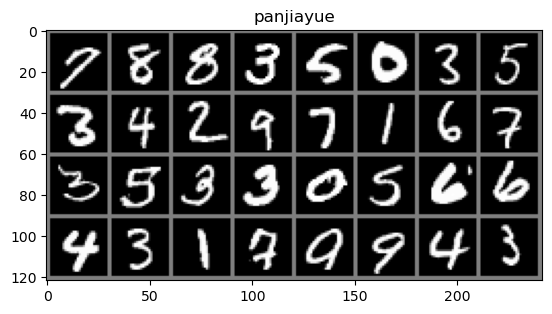

In [3]:
model = Model().cuda()#将这个模型转移到了GPU上
cost = torch.nn.CrossEntropyLoss()#交叉熵损失函数
optimizer = torch.optim.Adam(model.parameters())#创建了一个Adam优化器

#print(model) #打印网络结构

#print("len(data_train):",len(data_train))#60000#len(data_loader_train)=938
#print("len(data_test):",len(data_test))#10000#len(data_loader_test)=157
#60000=937*64+32
#10000=156*64+16  


# import os
# model_path = 'model_name.pth'
# model_params_path = 'params_name.pth'
# ----保存----
# torch.save(model, model_path)
# ----加载----
# model = torch.load(model_path)

has_been_trained = os.path.isfile(model_path)#判断模型是否已经被训练过
if has_been_trained:
    n_epochs = 0
else:
    n_epochs = 5


for epoch in range(n_epochs):
    running_loss = 0.0
    running_correct = 0#初始化了每个epoch的损失和正确预测的计数器
    print("Epoch {}/{}".format(epoch+1,n_epochs))
    print("-"*10)#print("$"*10)
    #cxq = 1
    for data in data_loader_train:#len(data_loader_train)=938
        X_train,y_train = data 
        # torch.Size([64, 1, 28, 28])和torch.Size([64])
        #938 torch.Size([32, 1, 28, 28])和938 torch.Size([32])
        X_train,y_train = X_train.cuda(),y_train.cuda()#从数据加载器中获取数据，并将其移动到GPU上
        
        #if cxq%50==0:
        # print("$"*10 + str(cxq))
        # cxq += 1
        # if cxq==10:
        #     break

        #X_train,y_train = Variable(X_train),Variable(y_train)#不加requires_grad默认为false
        ######################################################################################
        def closure():

            outputs = model(X_train)#输出torch.Size([64, 10])
            _,pred = torch.max(outputs.data,1)
            #返回每一行中最大值的那个元素，且返回其索引（返回最大元素在这一行的列索引）
            #输出torch.Size([64, 1])
            optimizer.zero_grad()
            loss = cost(outputs,y_train)
            #print("陈旭旗loss:",loss.data)
            loss.backward()
            #optimizer.step()
            global running_loss
            running_loss += loss.data
            #running_loss += loss.item()
            #print((pred == y_train.data).shape)
            global running_correct
            running_correct += torch.sum(pred == y_train.data)
            #running_correct += torch.sum(pred == y_train).item()
            '''
            ‌data‌：对数据进行（深）拷贝，将Variable变成tensor形式的数据，但不放入梯度图中，
            即不计算梯度。这意味着使用.data可以获取tensor的数据，而不会跟踪其计算历史或梯度信息
            ‌‌item()‌：将tensor类型数据中的单个元素值转换为Python的标量值。需要注意的是，item()只能用于包含单个值的tensor，
            如果tensor包含多个值，使用item()会报错。对于多维tensor，可以使用其他方法如tolist()来获取其值
            '''
            #(pred == y_train.data).shape=torch.Size([64])
            #mycxq = input("输入一个数字：")
            return loss
        optimizer.step(closure)
        
    testing_correct = 0
    #print("测试，测试-"*10)
    for data in data_loader_test:#len(data_loader_test)=157
        X_test,y_test = data 
        #torch.Size([64, 1, 28, 28])和torch.Size([64])
        #第157项torch.Size([16, 1, 28, 28])和torch.Size([16])
        X_test,y_test =X_test.cuda(),y_test.cuda()#移到GPU
        X_test,y_test = Variable(X_test),Variable(y_test)#打包
        outputs = model(X_test)#前向传播
        _,pred = torch.max(outputs.data,1)
        testing_correct += torch.sum(pred == y_test.data)
    print("Loss is:{:.4f},Train Accuracy is:{:.4f}%, Test Accuracy is:{:.4f}%".format(
        running_loss/len(data_train),100.0*running_correct/len(data_train),
        100.0*testing_correct/len(data_test)
        )
    )






#----保存----
# torch.save(model.state_dict(), model_params_path) #保存的文件名后缀一般是.pt或.pth
#----加载----
# model=Model().cuda() #定义模型结构
# model.load_state_dict(torch.load(model_params_path))  #加载模型参数

if has_been_trained:
    model = torch.load(model_path)
else:
    torch.save(model, model_path)


data_loader_test = torch.utils.data.DataLoader(
    dataset=data_test,
    batch_size = 32,
    shuffle=True
)

X_test, y_test = next(iter(data_loader_test))#获取一个批次的测试数据‌
X_test, y_test = X_test.cuda(), y_test.cuda()
inputs = Variable(X_test)#打包
pred = model(inputs)
_,pred = torch.max(pred,1)

print("计算机自动识别出的数字是:\n",[ i.item() for i in pred.data])
print("图片中实际表示的数字是:\n",[ i.item() for i in y_test])

#显示图像
img = torchvision.utils.make_grid(X_test)
img = img.cpu().numpy().transpose(1,2,0)

std = [0.5,0.5,0.5]#std = [0.5,0.5,0.5]
mean = [0.5,0.5,0.5]#mean = [0.5,0.5,0.5]
img = img * std + mean
plt.title("panjiayue")
plt.imshow(img)
plt.show()